
# Seller Churn Prediction – Case Study (Demo)

⚠️ **Note:**  
This is a **simplified demo notebook** with dummy features and synthetic data.  
The production version includes richer feature engineering, larger parameter grids, and proprietary business logic.  

---


!pip install shap
## Step 1 – Model Selection

We compare Logistic Regression, Random Forest, and LightGBM using cross-validation.  
Scoring is based on **average precision (PR AUC)**, which is suitable for imbalanced churn data.  


In [4]:
!pip install shap
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 92.8 MB/s eta 0:00:00:00:01


In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve,
    precision_score, recall_score, f1_score
)

# Generate dummy dataset
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    weights=[0.7, 0.3],
    random_state=42
)
X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(10)])

# CV strategy
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Logistic Regression
pipe_lr = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=1000))])
param_lr = {"lr__C": [0.01, 0.1, 1, 10]}

# Random Forest
rf = RandomForestClassifier(random_state=42)
param_rf = {"n_estimators": [200], "max_depth": [5, None]}

# LightGBM
lgbm = LGBMClassifier(random_state=42, verbose=-1)
param_lgbm = {"n_estimators": [200, 500], "num_leaves": [15, 31], "learning_rate": [0.01, 0.05]}

models_params = [
    ("Logistic Regression", pipe_lr, param_lr),
    ("Random Forest", rf, param_rf),
    ("LightGBM", lgbm, param_lgbm),
]

for name, model, params in models_params:
    grid = RandomizedSearchCV(model, params, cv=cv, scoring="average_precision", n_iter=3)
    grid.fit(X, y)
    print(f"{name} best score: {grid.best_score_:.3f}, params: {grid.best_params_}")


Logistic Regression best score: 0.694, params: {'lr__C': 0.1}
Random Forest best score: 0.938, params: {'n_estimators': 200, 'max_depth': None}
LightGBM best score: 0.952, params: {'num_leaves': 15, 'n_estimators': 500, 'learning_rate': 0.05}



## Step 2 – Model Training & Threshold Tuning

We choose **LightGBM** as the best-performing model.  
Threshold tuning ensures Precision ≥ 0.85 while maximizing Recall.  


In [6]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# LightGBM model
lgbm = LGBMClassifier(class_weight="balanced", random_state=42, n_estimators=200)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-val predictions
y_prob_cv = cross_val_predict(lgbm, X_train, y_train, cv=kf, method="predict_proba")[:, 1]

# Threshold tuning
thresholds = np.arange(0.0, 1.01, 0.01)
results = []
for t in thresholds:
    preds = (y_prob_cv >= t).astype(int)
    results.append([t,
        precision_score(y_train, preds),
        recall_score(y_train, preds),
        f1_score(y_train, preds)])
results_df = pd.DataFrame(results, columns=["Threshold","Precision","Recall","F1"])

best_row = results_df[results_df["Precision"] >= 0.85].iloc[0]
final_threshold = best_row["Threshold"]

# Retrain on full train set
lgbm.fit(X_train, y_train)
y_pred_test = (lgbm.predict_proba(X_test)[:, 1] >= final_threshold).astype(int)

print(classification_report(y_test, y_pred_test))
print(f"Chosen Threshold={final_threshold:.2f}, Precision={best_row['Precision']:.2f}, Recall={best_row['Recall']:.2f}")


              precision    recall  f1-score   support

           0       0.98      0.94      0.96       139
           1       0.87      0.97      0.91        61

    accuracy                           0.94       200
   macro avg       0.93      0.95      0.94       200
weighted avg       0.95      0.94      0.95       200

Chosen Threshold=0.07, Precision=0.85, Recall=0.95



## Step 3 – Feature Importance (SHAP)

SHAP values help explain which features contribute most to churn predictions.  
Positive SHAP = higher churn risk, Negative SHAP = lower churn risk.  


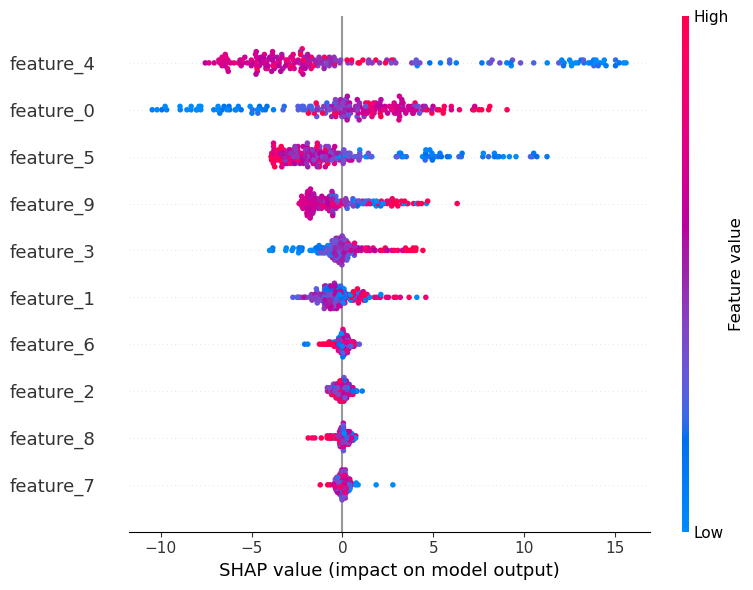

In [8]:

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_size=(8,6))



## Step 4 – Feature Direction & Grouping

We examine correlations between feature values and SHAP contributions.  
This shows the **direction of impact** and highlights feature groups.  


     feature  feature_shap_corr  mean_abs_shap
4  feature_4          -0.767149       5.124955
0  feature_0           0.813631       3.204284
5  feature_5          -0.728188       2.779735
9  feature_9           0.017549       1.533896
3  feature_3           0.846189       0.987797
1  feature_1           0.281003       0.903176
6  feature_6          -0.093037       0.279207
2  feature_2          -0.300826       0.265232
8  feature_8          -0.392225       0.248103
7  feature_7          -0.227677       0.228525


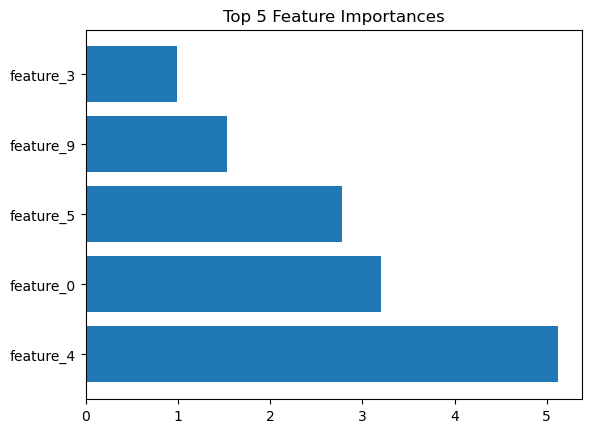

In [9]:

shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

directional_scores = {
    col: np.corrcoef(X_test[col], shap_df[col])[0,1]
    for col in X_test.columns
}
direction_table = pd.DataFrame(directional_scores.items(), columns=["feature","feature_shap_corr"])
direction_table["mean_abs_shap"] = shap_df.abs().mean().values
direction_table.sort_values("mean_abs_shap", ascending=False, inplace=True)
print(direction_table.head(10))

plt.barh(direction_table["feature"][:5], direction_table["mean_abs_shap"][:5])
plt.title("Top 5 Feature Importances")
plt.show()



## Step 5 – Feature Thresholds

For each feature, we estimate a **turning point threshold** where churn risk drops.  


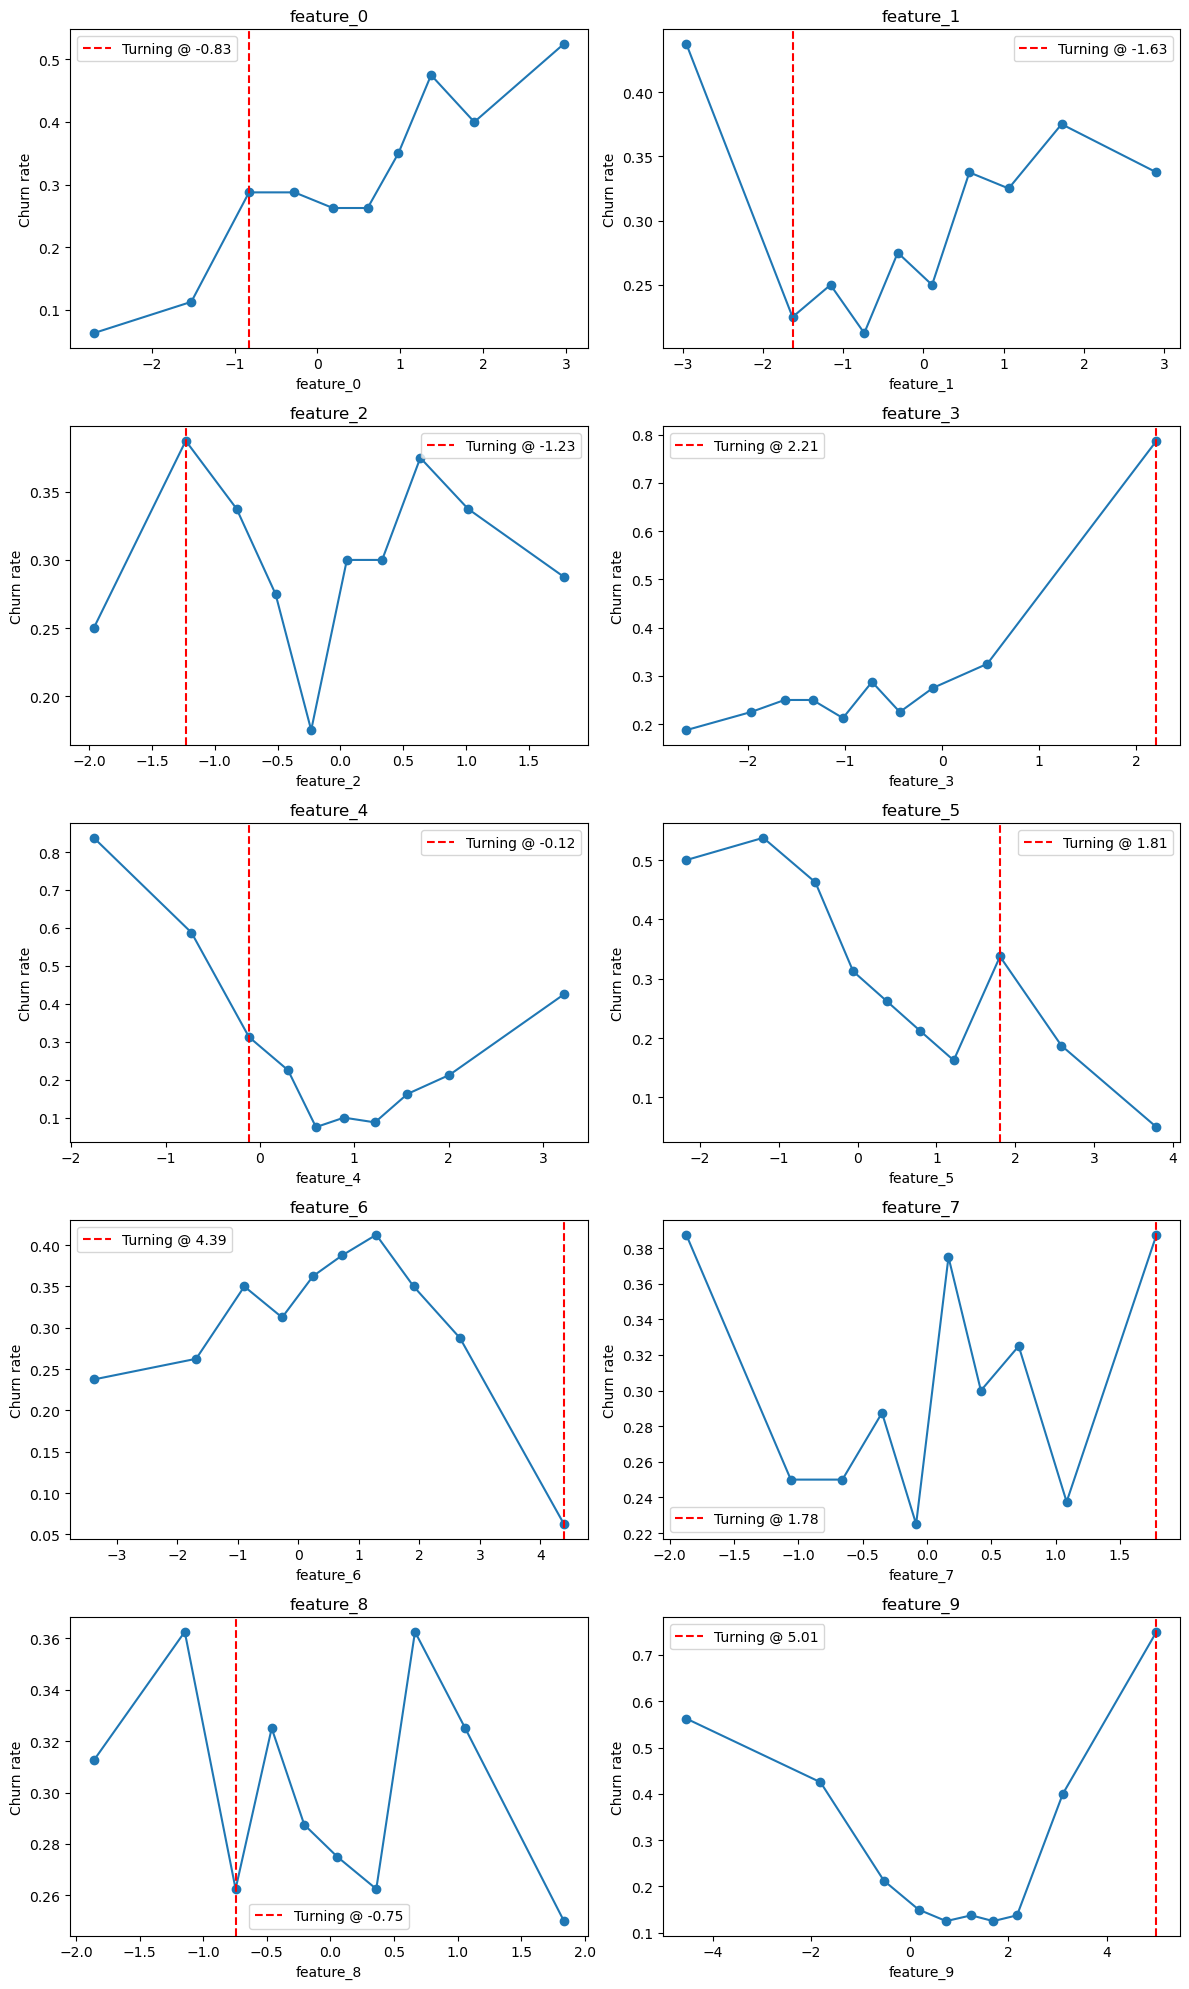

{'feature_0': {'bin_ranges': ['(-3.493, -1.907]', '(-1.907, -1.138]', '(-1.138, -0.514]', '(-0.514, -0.0401]', '(-0.0401, 0.413]', '(0.413, 0.799]', '(0.799, 1.156]', '(1.156, 1.588]', '(1.588, 2.199]', '(2.199, 3.754]'], 'churn_rates': [0.0625, 0.1125, 0.2875, 0.2875, 0.2625, 0.2625, 0.35, 0.475, 0.4, 0.525], 'turning_point': -0.826}, 'feature_1': {'bin_ranges': ['(-4.010000000000001, -1.896]', '(-1.896, -1.364]', '(-1.364, -0.95]', '(-0.95, -0.524]', '(-0.524, -0.115]', '(-0.115, 0.33]', '(0.33, 0.814]', '(0.814, 1.308]', '(1.308, 2.133]', '(2.133, 3.671]'], 'churn_rates': [0.4375, 0.225, 0.25, 0.2125, 0.275, 0.25, 0.3375, 0.325, 0.375, 0.3375], 'turning_point': -1.63}, 'feature_2': {'bin_ranges': ['(-2.463, -1.463]', '(-1.463, -0.999]', '(-0.999, -0.653]', '(-0.653, -0.38]', '(-0.38, -0.0853]', '(-0.0853, 0.188]', '(0.188, 0.476]', '(0.476, 0.796]', '(0.796, 1.236]', '(1.236, 2.323]'], 'churn_rates': [0.25, 0.3875, 0.3375, 0.275, 0.175, 0.3, 0.3, 0.375, 0.3375, 0.2875], 'turning_poi

In [14]:
# STEP 5: FEATURE OPTIMAL THRESHOLD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def feature_thresholds_with_plots(X, y, bins=10, cap_pct=0.01):
    data = X.copy()
    data['churn'] = y
    results = {}

    # Create subplots (2 columns layout)
    fig, axes = plt.subplots(
        nrows=(len(X.columns) + 1) // 2, 
        ncols=2, 
        figsize=(12, 4 * ((len(X.columns) + 1) // 2))
    )
    axes = axes.flatten()

    for i, col in enumerate(X.columns):
        if not np.issubdtype(data[col].dtype, np.number):
            continue

        # Cap outliers (winsorize)
        lower = data[col].quantile(cap_pct)
        upper = data[col].quantile(1 - cap_pct)
        capped = data[col].clip(lower, upper)

        # Bin into quantiles
        data['bin'] = pd.qcut(capped, q=bins, duplicates='drop')
        churn_rate = data.groupby('bin')['churn'].mean()

        # Compute midpoints manually
        bin_midpoints = [(interval.left + interval.right) / 2 for interval in churn_rate.index]

        # Find turning point (largest drop)
        diffs = churn_rate.diff().abs().fillna(0)
        max_interval = diffs.idxmax()                             # this is Interval
        turning_value = bin_midpoints[diffs.index.get_loc(max_interval)]

        # Save results
        results[col] = {
            'bin_ranges': churn_rate.index.astype(str).tolist(),
            'churn_rates': churn_rate.values.tolist(),
            'turning_point': turning_value
        }

        # Plot
        axes[i].plot(bin_midpoints, churn_rate, marker="o")
        axes[i].axvline(turning_value, color="red", linestyle="--", 
                        label=f"Turning @ {turning_value:.2f}")
        axes[i].set_title(col)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Churn rate")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

    return results


# Example run (using training set for demo)
thresholds = feature_thresholds_with_plots(X_train, y_train)
print(thresholds)



---

## Conclusion

- LightGBM achieved strong performance with Precision ≥ 0.85 and Recall trade-off.  
- SHAP analysis showed which features most influence churn risk.  
- Threshold analysis provided practical cutoffs to guide business action.  

⚠️ Reminder: This is a **simplified demo**.  
The full production version included more features, advanced parameter tuning, and richer business interpretation.  
